<img src="tic3151.png" style="height: 70px; width: 200px" align=left> 
<img src="logo-MMU.png" style="height: 70px; width: 200px" align=right> 

### Team members

Ahmad Ayaan - 1191302794 

Salah Fayeq y. AlHaismawi - 1201303035

Aisha Sakinah Binti Saadon - 1191101867

Aryssa Amanda Binti Azhar - 1191100575


### The assignment contains following questions


# Installing Libraries

##### Note: Uncomment the code the code to install the relevant libraries

In [1]:
# pip install matplotlib.pyplot

# Importing Libraries

In [2]:
from random import randint
import random
from tabulate import tabulate
import matplotlib.pyplot as plt
import constraint

# Question 1

Year-end school holiday is coming soon. A kindergarten teacher would like to give each
of the student in her class, an amazing holiday set by November 2023. There are 25
students in her class consisting of 15 girls and 10 boys. She has approached you for
help and provided the following details to you:

• Budget for 25 holiday sets = RM 200.00

• Each holiday set must be wrapped using a sheet of paper i.e. blue wrapper for
boy’s holiday set and pink wrapper for girl’s holiday set. Each wrapper cost
RM1.00

• Each holiday set should have at least 2 items being stationery



## Variables Declaration

In [3]:
# Constant variables
budget = 200.00
minimum_stationary_item = 2
wrapper_cost = 1.00

# List of items and their prices
items = [
    ("Chipsmore Biscuit", 2.00),
    ("2B pencil", 1.00),
    ("Color pencil", 3.00),
    ("Magic pen", 3.00),
    ("Potato chip", 2.00),
    ("Milo packet", 1.00),
    ("Mini sketch book", 2.00),
    ("Milk biscuit", 3.00)
]

mutation_rate = 0.1
wrapper_cost = 1 * 25  # Wrapper cost for 25 sets

## Population and Individuals



In [4]:
def individuals():
    return [random.randint(0, 1) for items in range(len(items))]

def generate_population(population_size):
    return [individuals() for x in range(population_size)]

## Fitness Function

The fitness function calculates the total cost of items in a chromosome, after deducting the cost of wrappers and ensuring that atleast 2 of the items are stationery.

In [5]:
def fitness_function(chromosome):
    total = 0
    num_stationery_items = 0
    num_items = 0
    for i, j in enumerate(chromosome):
        if j == 1:
            # to calculate the total cost of the items present in the set
            total += items[i][1]
            num_items += 1
            # to check if the current sets have stationery
            if items[i][0] in ["2B pencil", "Color pencil", "Magic pen", "Mini sketch book"]:
                num_stationery_items += 1

    if num_stationery_items >= 2 and (total*25) + wrapper_cost <=200:
         # Calculate the fitness score based on the weighted sum of total cost and number of items
        total_score = total * num_items
        items_score = num_items * 10
        score = total_score + items_score
        #print(score)
        return score
    else:
        return 0 if total <= 200 else -1

## Selection Function

In [6]:
"""Perform selection using roulette wheel selection."""
def selection_roulette_wheel(population, fitness_values):
    total_fitness = sum(fitness_values)
    if total_fitness == 0:
        probabilities = [1 / len(population)] * len(population)
    else:
        probabilities = [fitness / total_fitness for fitness in fitness_values]
    selected = random.choices(population, weights=probabilities, k=2)
    return selected[0], selected[1]


"""Perform selection using rank selection."""
def selection_rank(population, fitness_values):
    ranked_population = sorted(zip(population, fitness_values), key=lambda x: x[1], reverse=True)
    selected = []
    while len(selected) < 2:
        for chromosome, fitness in ranked_population:
            if fitness > 0:  # Select only individuals with positive fitness
                selected.append(chromosome.copy())
                if len(selected) == 2:
                    break
    return selected[0], selected[1]


## Crossover Function

In [7]:
"""Perform crossover using single point crossover."""
def crossover_single_point(parent1, parent2):
    single_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:single_point] + parent2[single_point:]
    child2 = parent2[:single_point] + parent1[single_point:]
    return child1, child2

"""Perform crossover using two point crossover."""
def crossover_two_point(parent1, parent2):
    two_point = sorted(random.sample(range(len(parent1)), 2))
    child1 = parent1[:two_point[0]] + parent2[two_point[0]:two_point[1]] + parent1[two_point[1]:]
    child2 = parent2[:two_point[0]] + parent1[two_point[0]:two_point[1]] + parent2[two_point[1]:]
    return child1, child2

## Mutation Function

In [8]:
"""Perform inversion mutation."""
def mutation_inversion(chromosome):
    start = random.randint(0, len(chromosome) - 1)
    end = random.randint(start + 1, len(chromosome))
    mutated_chromosome = chromosome[:start] + chromosome[start:end][::-1] + chromosome[end:]
    return mutated_chromosome

"""Perform bit flipping mutation."""
def mutation_bit_flip(chromosome):
    mutated_chromosome = chromosome[:]
    for i in range(len(mutated_chromosome)):
        if random.random() < mutation_rate:
            mutated_chromosome[i] = 1 - mutated_chromosome[i]
    return mutated_chromosome

## Main Function

In [9]:
def evolve(population, fitness_values, selection_method, crossover_method, mutation_method):
    next_generation = []
    while len(next_generation) < 25:
        parent1, parent2 = selection_method(population, fitness_values)
        #print(parent1, parent2)
        offspring1, offspring2 = crossover_method(parent1, parent2)
        #print(offspring1, offspring2)
        offspring1 = mutation_method(offspring1)
        offspring2 = mutation_method(offspring2)
        next_generation.extend([offspring1, offspring2])
        #print(next_generation)
    return next_generation[:25]


In [13]:
def main(selection_method, crossover_method, mutation_method):
    # Generate an initial population
    population = generate_population(25)
    
    # Calculate fitness values for each chromosome
    fitness_values = [fitness_function(chromosome) for chromosome in population]
    fitness_history = []

    best_fitness = float('inf')
    best_combination = []

    for generation in range(150):
        # Select parents and perform crossover and mutation
        population = evolve(population, fitness_values, selection_method, crossover_method, mutation_method)

        # Calculate fitness values for each chromosome
        fitness_values = [fitness_function(chromosome) for chromosome in population]
        fitness_history.append(max(fitness_values))

       # Find the best fitness value and corresponding combination
    best_fitness = max(fitness_values)
    best_combination = population[fitness_values.index(best_fitness)].copy()


    # Display the total combination and the content of the combination
    print("Total Combination of Items: ")
    total_combination = sum(best_combination)
    print(total_combination)

    print("Content of the Combination of Items:")
    selected_items = []
    unit_price = 0
    for i, item in enumerate(best_combination):
        if item == 1:
            item_name = items[i][0]
            item_price = items[i][1]
            unit_price += item_price
            selected_items.append([item_name, item_price])
            
    selected_items.append(['Wrapper cost', '1'])
    unit_price +=1
    print(tabulate(selected_items, headers=["Item Name", "Price (RM)"], tablefmt="grid"))

    print("Unit Price: ")
    print(unit_price if best_fitness >= 0 else 0)
    
    print("Total Price: ")
    print(unit_price * 25 if best_fitness >= 0 else 0)
    
    return best_combination, fitness_history


## Perfomance Assessment



In [16]:
# Test 1
print("Best holiday set (Selection Method: Ranked, Crossover Method: Single Point, Mutation Method: Inversion):")
print()
best_holiday_set_1, fitness_history_1 = main(selection_roulette_wheel, crossover_two_point, mutation_bit_flip)

Best holiday set (Selection Method: Ranked, Crossover Method: Single Point, Mutation Method: Inversion):

Total Combination of Items: 
4
Content of the Combination of Items:
+--------------+--------------+
| Item Name    |   Price (RM) |
+==============+==============+
| 2B pencil    |            1 |
+--------------+--------------+
| Magic pen    |            3 |
+--------------+--------------+
| Potato chip  |            2 |
+--------------+--------------+
| Milo packet  |            1 |
+--------------+--------------+
| Wrapper cost |            1 |
+--------------+--------------+
Unit Price: 
8.0
Total Price: 
200.0


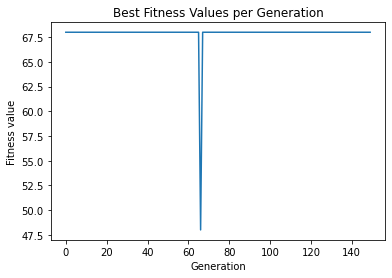

In [18]:
x = range(0,len(fitness_history_1))
y = fitness_history_1

plt.plot(x, y)

plt.title("Best Fitness Values per Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness value")

plt.show()

## Summary


# Question 2



## Defining variables

In [60]:
# Create a problem instance
problem = constraint.Problem()

# Define the variables
teams = range(1, 8)
days = range(1, 5)
time_slots = range(0, 24, 4)


# Add variables to the problem
for team in teams:
    problem.addVariable(team, days)
    for day in days:
        problem.addVariable(f"time_{team}_{day}", time_slots)

## Defining constraints

In [61]:
# Define the constraints
def each_team_four_hours(*args):
    return sum(args) == 4

def no_team_more_than_four_hours(*args):
    return sum(args) <= 4

def at_least_eight_hours(*args):
    return sum(args) >= 8


def dodol_feast():
    # Constraint 1: Each team should stir the pot of dodol for 4 hours on each day
    for day in days:
        problem.addConstraint(each_team_four_hours, [f"time_{team}_{day}" for team in teams])

    # Constraint 2: No team should stir the pot for more than 4 hours a day
    for team in teams:
        problem.addConstraint(no_team_more_than_four_hours, [f"time_{team}_{day}" for day in days])

    # Constraint 3: Each team should stir the pot for at least 8 hours during the entire dodol feast
    problem.addConstraint(at_least_eight_hours, [f"time_{team}_{day}" for team in teams for day in days])
    
    # Constraint 4:  No team should have consecutive shifts
    for team1 in teams:
        for team2 in teams:
            if team1 != team2:
                for day1 in days:
                    for day2 in days:
                        if day1 != day2:
                            problem.addConstraint(lambda t1, t2, d1, d2: (t1 + 4) % 8 <= t2 or (t2 + 4) % 8 <= t1,
                                                  (team1, team2, day1, day2))
    

    return problem

## Main Function

In [62]:
# Solve the CSP
problem_dodol = dodol_feast()
solutions = problem_dodol.getSolutions()

# Set the maximum number of solutions to display
max_solutions = 1

# Print the solutions
if solutions:
    print(f"Possible solutions ({min(max_solutions, len(solutions))} out of {len(solutions)}):")
    for i, solution in enumerate(solutions[:max_solutions]):
        print(f"Solution {i+1}:")
        for day, team in solution.items():
            print(f"Day {day}: Team {team}")
        print()
else:
    print("No solutions found.")

Possible solutions (1 out of 18480):
Solution 1:
Day 1: Team 4
Day 2: Team 4
Day 3: Team 4
Day 4: Team 4
Day 5: Team 4
Day 6: Team 4
Day 7: Team 4
Day time_1_1: Team 4
Day time_1_2: Team 0
Day time_1_3: Team 0
Day time_1_4: Team 0
Day time_2_1: Team 0
Day time_2_2: Team 4
Day time_2_3: Team 0
Day time_2_4: Team 0
Day time_3_1: Team 0
Day time_3_2: Team 0
Day time_3_3: Team 4
Day time_3_4: Team 0
Day time_4_1: Team 0
Day time_4_2: Team 0
Day time_4_3: Team 0
Day time_4_4: Team 4
Day time_5_1: Team 0
Day time_5_2: Team 0
Day time_5_3: Team 0
Day time_5_4: Team 0
Day time_6_1: Team 0
Day time_7_1: Team 0
Day time_6_2: Team 0
Day time_7_2: Team 0
Day time_6_3: Team 0
Day time_7_3: Team 0
Day time_6_4: Team 0
Day time_7_4: Team 0



## Summary

# Question 3


## Summary